In [1]:
import math
import tensorflow as tf
from tensorflow.contrib import learn
import numpy as np
import pylab as plt
import pickle
import os
import csv
import sys
import time
from datetime import timedelta
# import gensim
import sklearn

C:\Users\lzcai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
LEARNING_RATE = 0.01
EPOCHS = 2000
BATCH_SIZE = 128
MAX_DOC_LEN = 100
CHAR_DEPTH = 256
WORD_WIDTH = 20
NUM_CLASSES = 15
DROP = True
KEEP_PROB = 0.9

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
DATA_DIR = "../data"
SAVE_DIR = "../data/PartB_Result"
RESULT_DIR = "../data/PartB_Result/1112/Q5/2-0.9"
TRAIN_CHAR_FILENAME = "Train_char.out"
TEST_CHAR_FILENAME = "Test_char.out"
TRAIN_WORD_FILENAME = "Train_words_20.out"
TEST_WORD_FILENAME = "Test_words_20.out"

In [4]:
with open(os.path.join(SAVE_DIR, TRAIN_WORD_FILENAME),"rb") as f:
    trainX, tmp_trainY = pickle.load(f)

In [5]:
with open(os.path.join(SAVE_DIR, TEST_WORD_FILENAME),"rb") as f:
    testX, tmp_testY = pickle.load(f)

In [6]:
def generate_batch(X_in, y_in, batch_size):
    X = list(X_in)
    y = list(y_in)
    
    if len(X)!=len(y):
        print("Error: len(X)!=len(Y)")
        return None
    batched_X = []
    batched_y = []
    count = 0
    while (len(X) >= batch_size):
        batched_X.append(X[0:batch_size])
        del X[0:batch_size]
        batched_y.append(y[0:batch_size])
        del y[0:batch_size]
        if count % 10 == 0:
            print (count)
        count += 1
    
    if len(X) != 0:
        remain = batch_size-len(X)
        X.extend(batched_X[0][0:remain])
        y.extend(batched_y[0][0:remain])
        batched_X.append(X)
        batched_y.append(y)
        print(count, "Remain rescaled to", len(X))
    
    return (batched_X, batched_y)

In [7]:
trainY_targets = np.array(tmp_trainY).reshape(-1)
trainY = np.eye(NUM_CLASSES)[trainY_targets]

testY_targets = np.array(tmp_testY).reshape(-1)
testY = np.eye(NUM_CLASSES)[testY_targets]
# trainY = y_train
# testY = y_test

In [8]:
x_allBatch, y_allBatch = generate_batch(trainX, trainY, BATCH_SIZE)

0
10
20
30
40
43 Remain rescaled to 128


In [9]:
x_allBatch = np.array(x_allBatch)
y_allBatch = np.array(y_allBatch)

print(x_allBatch.shape)
print(y_allBatch.shape)

(44, 128, 100, 20)
(44, 128, 15)


In [10]:
def cnn(X):
#     X = tf.reshape(X, [-1, MAX_DOC_LEN, 1])
#     h = tf.layers.dense(X, WORD_WIDTH)
#     print(h)
    X = tf.cast(X, tf.float32)
    X = tf.reshape(X, [-1, MAX_DOC_LEN, WORD_WIDTH, 1])
    print(X)
    
    #Conv 1
    conv1 = tf.layers.conv2d(
      inputs = X,
      filters = 10,
      kernel_size = [20, 20],
      padding = "valid",
      activation = tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(
        inputs = conv1, 
        pool_size = [4, 4], 
        padding = "same",
        strides = 2)

    #Conv 2
    conv2 = tf.layers.conv2d(
      inputs = pool1,
      filters = 10,
      kernel_size=[20, 1],
      padding="valid",
      activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(
        inputs = conv2, 
        pool_size = [4, 4], 
        padding = "same",
        strides = 2)    

    #Softmax    

    dim = pool2.get_shape()[1].value * pool2.get_shape()[2].value * pool2.get_shape()[3].value 
    pool2_flat = tf.reshape(pool2, [-1, dim])

    W2 = tf.Variable(tf.truncated_normal([dim, NUM_CLASSES], stddev=1.0/np.sqrt(dim)), name='weights_3')
    b2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')
    
    logits = tf.matmul(pool2_flat, W2) + b2
    
    drop_out = tf.nn.dropout(logits, KEEP_PROB)

    return drop_out

In [11]:
def setup_cross_entropy(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

def setup_correct_prediction(labels, logits):
    return tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32)

In [12]:
x = tf.placeholder(tf.int32, [None, MAX_DOC_LEN, WORD_WIDTH])
d = tf.placeholder(tf.float32, [None, NUM_CLASSES])
y = cnn(x)

cross_entropy = setup_cross_entropy(labels=d, logits=y)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(loss)

Tensor("Reshape:0", shape=(?, 100, 20, 1), dtype=float32)


In [13]:
correct_prediction = setup_correct_prediction(labels=d, logits=y)
accuracy = tf.reduce_mean(correct_prediction)

In [14]:
saver = tf.train.Saver()
if not os.path.exists(RESULT_DIR):
    print("Not Exist")
    os.makedirs(RESULT_DIR)

In [15]:
def plot_graph(EPOCHS, BATCH_SIZE, acc_record, fileName, isTrain, error = False):
    if error:  
        acc_record = [1-tmp for tmp in acc_record]
        if isTrain:
            yLabel = 'Train error'
        else:
            yLabel = 'Test error'
    else:
        if isTrain:
            yLabel = 'Train accuracy'
        else:
            yLabel = 'Test accuracy'
    plt.figure(1)
    plt.plot(range(EPOCHS), acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel(yLabel)
    plt.ylim((0,1))
    plt.savefig(os.path.join(RESULT_DIR, fileName))
    plt.show()

In [16]:
def validation_accuracy(testX, testY):
    output_2_, accuracy_ = session.run([y, accuracy], feed_dict={x: testX, d: testY})
    print(output_2_, '\n',accuracy_)

In [17]:
train_acc_backup = []
test_acc_backup = []
time_usage_backup = []
total_time_backup = []

BATCH_SIZE= 128
iter 0: Train accuracy 0.328125 Test accuracy:  0.33857143 *
Time usage: 0:00:03
iter 50: Train accuracy 0.765625 Test accuracy:  0.50142854 *
Time usage: 0:00:16
iter 100: Train accuracy 0.78125 Test accuracy:  0.50714284 *
Time usage: 0:00:28
iter 150: Train accuracy 0.8125 Test accuracy:  0.47857141 
Time usage: 0:00:40
iter 200: Train accuracy 0.835938 Test accuracy:  0.4857143 
Time usage: 0:00:52
iter 250: Train accuracy 0.859375 Test accuracy:  0.47857141 
Time usage: 0:01:04
iter 300: Train accuracy 0.875 Test accuracy:  0.45 
Time usage: 0:01:16
iter 350: Train accuracy 0.867188 Test accuracy:  0.46571428 
Time usage: 0:01:29
iter 400: Train accuracy 0.875 Test accuracy:  0.47142857 
Time usage: 0:01:41
iter 450: Train accuracy 0.875 Test accuracy:  0.46285716 
Time usage: 0:01:53
iter 500: Train accuracy 0.859375 Test accuracy:  0.47428572 
Time usage: 0:02:06
iter 550: Train accuracy 0.84375 Test accuracy:  0.49 
Time usage: 0:02:18
iter 600: Train accuracy 0

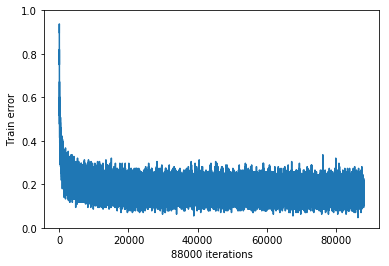

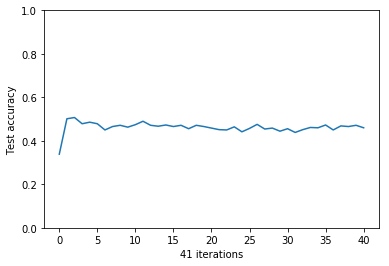

In [18]:
print("BATCH_SIZE=", BATCH_SIZE)
total_iterations = 0
train_acc = []
start_time = time.time()
train_acc_record = []
test_acc_record = []
epoch_time_record = []

best_test_acc = 0.0
last_improvement = 0
improved_str = ""
test_count = 0
train_count = 0
mul = int(len(trainX)/BATCH_SIZE)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(EPOCHS):
        epoch_start_time = time.time()
        
        for j in range(len(x_allBatch)): # 1. Use Sequenced Batch
#         for j in range(mul): # 2. Use Random Batch
            feed_dict_train = {x: x_allBatch[j], d: y_allBatch[j]} # 1. Use Sequenced Batch
#             x_batch, d_batch = next_batch(BATCH_SIZE, trainX, trainY) # 2. Use Random Batch
#             feed_dict_train = {x: x_batch, d: d_batch} # 2. Use Random Batch
            sess.run(train_op, feed_dict=feed_dict_train)
            train_acc_record.append(accuracy.eval(feed_dict=feed_dict_train))
            train_count += 1
            
        epoch_end_time = time.time()
        epoch_time_diff = epoch_end_time-epoch_start_time
        epoch_time_record.append(epoch_time_diff)

        if (i % 50 == 0) or (i == (EPOCHS - 1)):
            test_count += 1
            test_accuracy = sess.run(accuracy, feed_dict={x: testX, d: testY})
            test_acc_record.append(test_accuracy)
            if DROP:
                if test_accuracy > best_test_acc:
                    best_test_acc = test_accuracy
                    last_improvement = i
                    saver.save(sess=sess, save_path=RESULT_DIR)
                    improved_str = "*"
                else:
                    improved_str = ''
            else:
                saver.save(sess=sess, save_path=RESULT_DIR)

            print('iter %d: Train accuracy %g'%(i, train_acc_record[train_count-1]), 'Test accuracy: ',test_accuracy, improved_str)
            print("Time usage: " + str(timedelta(seconds=int(round(time.time()-start_time)))))


# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

train_graphName = "PartB-Q5-2-Train"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
test_graphName = "PartB-Q5-2-Test"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
plot_graph(train_count, BATCH_SIZE, train_acc_record,train_graphName, isTrain = True, error=True)
plot_graph(test_count, BATCH_SIZE, test_acc_record, test_graphName, isTrain = False)


train_acc_backup.append(train_acc_record)
test_acc_backup.append(test_acc_record)
time_usage_backup.append(epoch_time_record)
total_time_backup.append(time_dif)

#=========== Save all the data for EACH TRAINING Has Done ============#
fileNameTail = str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"

train_acc_filename = "PartB-Q5-2-Train_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, train_acc_filename), 'wb') as fp:
    pickle.dump(train_acc_backup, fp)

test_acc_filename = "PartB-Q5-2-Test_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, test_acc_filename), 'wb') as fp:
    pickle.dump(test_acc_backup, fp)

time_usage_filename = "PartB-Q5-2-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)

time_usage_filename = "PartB-Q5-2-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)        


In [19]:
# x_allBatch[0].shape